In [185]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.signature_tools
%matplotlib inline

from pygenesig.signature_tools import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skm 
import dask.dataframe as dd
import dask
import tempfile
from collections import OrderedDict
import seaborn as sns
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
from distributed import Executor, progress
e = Executor("10.114.185.14:8786")

In [187]:
!ls ../data/gtex

GTEx_Analysis_v6_RNA-seq_RNA-SeQCv1.1.8_gene_reads.gct	sigmat.all.gini
GTEx_Analysis_v6_RNA-seq_RNA-SeQCv1.1.8_gene_rpkm.gct	sigmat.rank1.gini
GTEx-UDISDataSetID5681-sampleAnnotation.txt		v6_UDIS.txt


In [188]:
annotation = pd.read_csv("../data/gtex/GTEx-UDISDataSetID5681-sampleAnnotation.txt", sep="\t", index_col=0)
tissue = pd.read_csv("../data/gtex/v6_UDIS.txt", sep="\t", index_col=0)

In [189]:
gct = pd.read_csv("../data/gtex/GTEx_Analysis_v6_RNA-seq_RNA-SeQCv1.1.8_gene_rpkm.gct", sep="\t", skiprows=2, index_col=0)

In [190]:
genenames = gct.Description
gct = gct.iloc[:, 1:]

In [191]:
assert len(gct.index) == len(genenames)
ensemble2hgnc = OrderedDict(
    (ens, hgnc.split(".")[0]) for (ens, hgnc) in zip(gct.index, genenames)
)
assert list(ensemble2hgnc.keys()) == list(gct.index)

In [192]:
col_vars = annotation.join(tissue, how="inner")

In [193]:
col_vars = col_vars[col_vars.index.isin(gct.columns)]

In [194]:
grouped = col_vars.groupby("SMTS")

In [195]:
tissue_count = grouped.count().iloc[:,1]
tissue_count

SMTS
Adipose Tissue      577
Adrenal Gland       145
Bladder              11
Blood               511
Blood Vessel        689
Brain              1259
Breast              214
Cervix Uteri         11
Colon               345
Esophagus           686
Fallopian Tube        6
Heart               412
Kidney               32
Liver               119
Lung                320
Muscle              430
Nerve               304
Ovary                97
Pancreas            171
Pituitary           103
Prostate            106
Salivary Gland       57
Skin                890
Small Intestine      88
Spleen              104
Stomach             192
Testis              172
Thyroid             323
Uterus               83
Vagina               96
Name: Experimental readout, dtype: int64

In [196]:
col_vars = col_vars[col_vars.SMTS.isin(tissue_count[tissue_count > 30].index)]

In [1]:
X = list(col_vars.index)
y = list(col_vars.SMTS)
skf = StratifiedKFold(n_splits=10)

NameError: name 'col_vars' is not defined

In [198]:
i_train = []
i_test = []
for train, test in skf.split(X, y):
    i_train.append(train)
    i_test.append(test)

In [199]:
def gini_wrapper(train_ind):
    """calculate gini-signatures for a training set"""
    sig = mk_gini_signature(gct, col_vars, subset=train_ind, tissue_col="SMTS", min_gini=.9)
    sig_hgnc = {tissue: set([ensemble2hgnc[ens] for ens in genes]) for tissue, genes in sig.items()}
    return(sig_hgnc)

In [200]:
s1 = gini_wrapper(i_train[0])

In [201]:
{sig: len(genes) for sig, genes in s1.items()}

{'Adipose Tissue': 42,
 'Adrenal Gland': 125,
 'Blood': 349,
 'Blood Vessel': 135,
 'Brain': 167,
 'Breast': 7,
 'Colon': 15,
 'Esophagus': 37,
 'Heart': 244,
 'Kidney': 51,
 'Liver': 246,
 'Lung': 25,
 'Muscle': 429,
 'Nerve': 42,
 'Ovary': 110,
 'Pancreas': 162,
 'Pituitary': 28,
 'Prostate': 4,
 'Salivary Gland': 22,
 'Skin': 127,
 'Small Intestine': 19,
 'Spleen': 95,
 'Stomach': 29,
 'Testis': 9,
 'Thyroid': 29,
 'Uterus': 87,
 'Vagina': 23}

In [202]:
#fsigs = e.map(gini_wrapper, i_train)

In [203]:
gmt_file = tempfile.NamedTemporaryFile()
write_gmt(s1, gmt_file.name)

In [204]:
eset = mk_eset(gct.as_matrix(), np.array(list(ensemble2hgnc.values())))

In [205]:
gmt = read_gmt(gmt_file.name)

In [207]:
bioqc_res = wmw_test(eset, gmt, valType=("p.greater"), col="GeneSymbols")

In [209]:
bioqc_res_log = -np.log10(np.array(bioqc_res))

In [210]:
sigs_sorted = list(base.names(gmt))

In [211]:
res_test = bioqc_res_log[:, i_test[0]]

In [212]:
sig_test = np.argmax(res_test, axis=0)

In [213]:
sig_test_named = [sigs_sorted[i] for i in sig_test]
predicted = sig_test_named

In [214]:
actual = col_vars.iloc[i_test[0], :].SMTS

In [215]:
assert len(actual) == len(predicted), "length of predicted and actual do not match. "

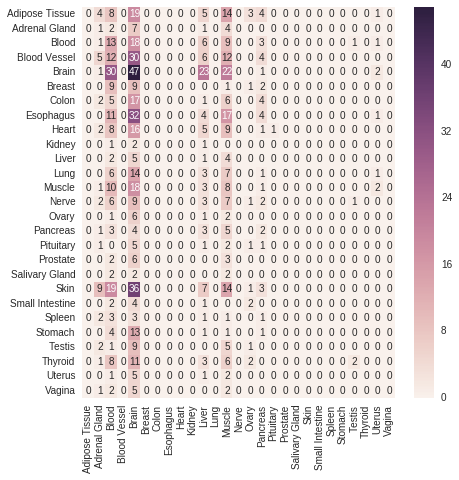

In [216]:
fix, ax = subplots(figsize=(7, 7))
sns.heatmap(skm.confusion_matrix(actual, predicted), ax=ax, annot=True, xticklabels=sigs_sorted, yticklabels=sigs_sorted)

In [ ]:
for tissue in sigs_sorted: 
    actual = [tissue if b else 'other' for b in col_vars[i_test[0], :].SMTS == tissue]
    predicted = [tissue if b else 'other' for b in sig_test_named == tissue]
    